In [1]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.8 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=83ca

# Import Dataset

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="J1rWUvuwvKwOyLI5ooEK")
project = rf.workspace("sanjana-kazi-supti-ymhu2").project("final-1yr0d-wo5ot")
version = project.version(1)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30


Extracting Dataset Version Zip to Final-1 in coco:: 100%|██████████| 4295/4295 [00:01<00:00, 3485.67it/s]


# Fix the error in the json file

In [3]:
import json
from pathlib import Path

# ===== Path to your COCO dataset folder =====
dataset_dir = Path("/kaggle/working/Final-1")

# ===== Function to convert JSON to single-class =====
def convert_to_one_class(json_file):
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # Step 1: Keep only one category
    coco_data["categories"] = [{"id": 1, "name": "Sunflower"}]

    # Step 2: Remap all annotations to category_id = 1
    for ann in coco_data["annotations"]:
        ann["category_id"] = 1

    # Step 3: Save back (overwrite original)
    with open(json_file, "w") as f:
        json.dump(coco_data, f, indent=2)

    print(f"Converted: {json_file}")

# ===== Loop over train, valid, test annotation files =====
for split in ["train", "valid", "test"]:
    json_path = dataset_dir / split / "_annotations.coco.json"
    if json_path.exists():
        convert_to_one_class(json_path)
    else:
        print(f"⚠ No JSON file found for {split}")

print("All done! Update YAML with:")
print('nc: 1\nnames: ["Sunflower"]')


Converted: /kaggle/working/Final-1/train/_annotations.coco.json
Converted: /kaggle/working/Final-1/valid/_annotations.coco.json
Converted: /kaggle/working/Final-1/test/_annotations.coco.json
All done! Update YAML with:
nc: 1
names: ["Sunflower"]


# Setup

In [4]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# Path Declaration and COCO --> YOLO Conversion

In [5]:
import json
import shutil
import random
from pathlib import Path
import yaml
from ultralytics import YOLO

# ================================
# 1. Define Paths
# ================================
COCO_ROOT     =  Path("/kaggle/working/Final-1")  # folder with train/ and valid/
TRAIN_IMG_DIR = COCO_ROOT / "train"
TRAIN_ANN     = TRAIN_IMG_DIR / "_annotations.coco.json"
VAL_IMG_DIR   = COCO_ROOT / "valid"
VAL_ANN       = VAL_IMG_DIR / "_annotations.coco.json"

WORK          = Path("/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset")
SPLIT         = WORK / "0_yolo_split"       # YOLO-format dataset split
PSEUDO        = WORK / "1_pseudo"           # Pseudo-label storage
STU_ROOT      = WORK / "2_student"          # Student dataset (GT + pseudo)

# ================================
# 2. Create Folder Structure
# ================================
for split in ["train", "valid", "test"]:
    (SPLIT / split / "images").mkdir(parents=True, exist_ok=True)
    (SPLIT / split / "labels").mkdir(parents=True, exist_ok=True)

(PSEUDO / "raw").mkdir(parents=True, exist_ok=True)

for split in ["train", "valid"]:
    (STU_ROOT / split / "images").mkdir(parents=True, exist_ok=True)
    (STU_ROOT / split / "labels").mkdir(parents=True, exist_ok=True)

# ================================
# 3. Load Classes from COCO
# ================================
cats = json.load(open(TRAIN_ANN))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
nc = len(names)

# ================================
# 4. COCO → YOLO Conversion
# ================================
def coco2yolo(b, w, h):
    x, y, ww, hh = b
    return (x + ww / 2) / w, (y + hh / 2) / h, ww / w, hh / h

def convert_split(split, img_dir, ann_json):
    coco = json.load(open(ann_json))
    id2img = {img["id"]: img for img in coco["images"]}
    out_im = SPLIT / split / "images"
    out_lb = SPLIT / split / "labels"

    # Write YOLO label files
    for ann in coco["annotations"]:
        img = id2img[ann["image_id"]]
        w, h = img["width"], img["height"]
        yb = coco2yolo(ann["bbox"], w, h)
        cls = ann["category_id"] - 1
        p = out_lb / f"{Path(img['file_name']).stem}.txt"
        with open(p, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

    # Copy images
    for img in coco["images"]:
        shutil.copy(Path(img_dir) / img["file_name"], out_im / img["file_name"])

convert_split("train", TRAIN_IMG_DIR, TRAIN_ANN)
convert_split("valid", VAL_IMG_DIR, VAL_ANN)
convert_split("test", TRAIN_IMG_DIR, TRAIN_ANN)  # Use train as test if no separate test set
print("COCO to YOLO conversion completed.")

COCO to YOLO conversion completed.


# Dataset splitting and directory setup for teacher-student training

In [6]:
# ================================
# 5. Split labeled/unlabeled data from 20% labeled portion
# ================================
LABELED_RATIO = 0.3
random.seed(42)

all_train_images = list((SPLIT / "train" / "images").glob("*.jpg"))
random.shuffle(all_train_images)

num_labeled = int(len(all_train_images) * LABELED_RATIO)
labeled_images = all_train_images[:num_labeled]
unlabeled_images = all_train_images[num_labeled:]

print(f"Total train images: {len(all_train_images)}")
print(f"Labeled images (20%): {len(labeled_images)}")
print(f"Unlabeled images (80%): {len(unlabeled_images)}")

# Further split labeled into train (90%) and val (10%)
val_ratio = 0.1
num_val = int(len(labeled_images) * val_ratio)
random.shuffle(labeled_images)
val_images = labeled_images[:num_val]
train_images_for_teacher = labeled_images[num_val:]

print(f"Teacher train images (90% of 20%): {len(train_images_for_teacher)}")
print(f"Teacher val images (10% of 20%): {len(val_images)}")

# Create directories
LABELED_TRAIN_IMG_DIR = WORK / "labeled_train" / "images"
LABELED_TRAIN_LB_DIR  = WORK / "labeled_train" / "labels"
LABELED_VAL_IMG_DIR   = WORK / "labeled_val" / "images"
LABELED_VAL_LB_DIR    = WORK / "labeled_val" / "labels"
UNLABELED_IMG_DIR     = WORK / "unlabeled" / "images"

for d in [LABELED_TRAIN_IMG_DIR, LABELED_TRAIN_LB_DIR, LABELED_VAL_IMG_DIR, LABELED_VAL_LB_DIR, UNLABELED_IMG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Copy train images + labels
for img_path in train_images_for_teacher:
    shutil.copy(img_path, LABELED_TRAIN_IMG_DIR / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, LABELED_TRAIN_LB_DIR / label_path.name)

# Copy val images + labels
for img_path in val_images:
    shutil.copy(img_path, LABELED_VAL_IMG_DIR / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, LABELED_VAL_LB_DIR / label_path.name)

# Copy unlabeled images only
for img_path in unlabeled_images:
    shutil.copy(img_path, UNLABELED_IMG_DIR / img_path.name)

# Copy validation set (from original valid) to STU_ROOT for student eval
(STU_ROOT / "valid" / "images").mkdir(parents=True, exist_ok=True)
(STU_ROOT / "valid" / "labels").mkdir(parents=True, exist_ok=True)
for img in (SPLIT / "valid" / "images").glob("*.*"):
    shutil.copy(img, STU_ROOT / "valid" / "images" / img.name)
    lbl = SPLIT / "valid" / "labels" / f"{img.stem}.txt"
    if lbl.exists():
        shutil.copy(lbl, STU_ROOT / "valid" / "labels" / lbl.name)

# Copy teacher training set to STU_ROOT/train (needed for pseudo-label merging)
(STU_ROOT / "train" / "images").mkdir(parents=True, exist_ok=True)
(STU_ROOT / "train" / "labels").mkdir(parents=True, exist_ok=True)
for img_path in train_images_for_teacher:
    shutil.copy(img_path, STU_ROOT / "train" / "images" / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, STU_ROOT / "train" / "labels" / label_path.name)

print("Data splitting and copying done.")

Total train images: 3957
Labeled images (20%): 1187
Unlabeled images (80%): 2770
Teacher train images (90% of 20%): 1069
Teacher val images (10% of 20%): 118
Data splitting and copying done.


# Dataset YAML preparation for teacher–student pipeline

In [7]:
# ================================
# 6. Prepare YAML files
# ================================
teacher_data_yaml = {
    'path': str(WORK / "labeled_train"),
    'train': 'images',
    'val': str(LABELED_VAL_IMG_DIR),  # Use absolute path for val
    'nc': nc,
    'names': names
}
teacher_data_yaml_path = WORK / "teacher_data.yaml"
teacher_data_yaml_path.write_text(yaml.dump(teacher_data_yaml))

student_data_yaml = {
    'path': str(STU_ROOT),
    'train': 'train/images',
    'val': 'valid/images',
    'nc': nc,
    'names': names
}
student_data_yaml_path = WORK / "data_Sunflower_student.yaml"
student_data_yaml_path.write_text(yaml.dump(student_data_yaml))

print("YAML files prepared.")

YAML files prepared.


# Two-phase teacher training: freeze backbone, then unfreeze for fine-tuning

In [8]:
# ================================
# 7. Teacher training with frozen backbone then fine-tuning
# ================================

# Use pretrained YOLOv12s instead of local best.pt
teacher = YOLO("yolo12s.pt")  

# Freeze first 25% backbone layers
backbone = teacher.model.model[0]
backbone_layers = list(backbone.children())
total_layers = len(backbone_layers)
freeze_count = int(total_layers * 0.25)
for i, layer in enumerate(backbone_layers):
    if i < freeze_count:
        layer.eval()
        for param in layer.parameters():
            param.requires_grad = False
print(f"Frozen {freeze_count}/{total_layers} backbone layers.")

teacher.train(
    data=str(teacher_data_yaml_path),
    epochs=5,
    imgsz=640,
    batch=12,
    project=str(WORK),
    name="teacher_partial_freeze",
    device=0,
    lr0=0.001,
    lrf=0.1,
    momentum=0.937,
    weight_decay=0.0005,
    cos_lr=True,
    save=True,
)

# Unfreeze all layers for fine-tuning
for param in teacher.model.parameters():
    param.requires_grad = True
print("All layers unfrozen for fine-tuning.")

last_checkpoint = WORK / "teacher_partial_freeze" / "weights" / "last.pt"

teacher.train(
    data=str(teacher_data_yaml_path),
    epochs=50,
    imgsz=640,
    batch=12,
    project=str(WORK),
    name="teacher_final",
    device=0,
    lr0=0.0005,
    lrf=0.05,
    momentum=0.937,
    weight_decay=0.0005,
    cos_lr=True,
    save=True,
    resume=False,
    pretrained=str(last_checkpoint)  # load last checkpoint from frozen phase
)

teacher_weights = WORK / "teacher_final" / "weights" / "best.pt"
print(f"Teacher final model saved to {teacher_weights}")


Frozen 0/3 backbone layers.
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_partial_freeze, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2213.6±481.7 MB/s, size: 105.6 KB)


train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels... 1069 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1069/1069 [00:00<00:00, 1131.87it/s]

train: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 469.4±76.1 MB/s, size: 90.5 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels... 118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 118/118 [00:00<00:00, 506.01it/s]

val: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.58G      1.751      1.208      1.223        346        640: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]

                   all        118      10404      0.696      0.584      0.663      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      6.95G      1.598     0.8848      1.121         61        640: 100%|██████████| 90/90 [00:31<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.797       0.72      0.818      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.98G      1.553     0.8452      1.094        107        640: 100%|██████████| 90/90 [00:31<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]

                   all        118      10404      0.784      0.768      0.823      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.02G      1.513     0.8164      1.073         51        640: 100%|██████████| 90/90 [00:31<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.836       0.78      0.869      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.06G      1.435      0.757      1.054         70        640: 100%|██████████| 90/90 [00:31<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.826      0.786      0.867      0.487



5 epochs completed in 0.048 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 4/5 [00:10<00:02,  2.41s/it]

WARNING ⚠️ NMS time limit 3.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]
invalid value encountered in less
invalid value encountered in less


                   all        118      10404      0.837      0.774      0.863      0.494
Speed: 0.2ms preprocess, 8.7ms inference, 0.0ms loss, 38.4ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze
All layers unfrozen for fine-tuning.
Transferred 691/691 items from pretrained weights
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels.cache... 1069 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1069/1069 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 410.1±51.7 MB/s, size: 90.5 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache... 118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 118/118 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.09G      1.427     0.7573      1.048        346        640: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

                   all        118      10404      0.815      0.745      0.834      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.35G      1.473     0.7787      1.064         61        640: 100%|██████████| 90/90 [00:32<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

                   all        118      10404      0.802      0.749       0.84      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.55G      1.512      0.818      1.072        107        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all        118      10404      0.793      0.745      0.823      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.59G      1.541     0.8289      1.077         51        640: 100%|██████████| 90/90 [00:32<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all        118      10404      0.816      0.785      0.861      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.63G      1.503     0.8102      1.077         70        640: 100%|██████████| 90/90 [00:31<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

                   all        118      10404      0.805      0.759      0.846      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.67G      1.473      0.796      1.056         68        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

                   all        118      10404      0.839       0.77      0.863      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.71G       1.47     0.7865      1.059         45        640: 100%|██████████| 90/90 [00:31<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

                   all        118      10404      0.819      0.784      0.859      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.71G      1.463     0.7742       1.05         67        640: 100%|██████████| 90/90 [00:32<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]

                   all        118      10404      0.824      0.787      0.863      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.71G      1.451     0.7622      1.045        100        640: 100%|██████████| 90/90 [00:32<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all        118      10404      0.839      0.785      0.876      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.71G      1.431     0.7616      1.041        181        640: 100%|██████████| 90/90 [00:32<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]

                   all        118      10404      0.826      0.792      0.872      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.71G      1.432     0.7541      1.037        108        640: 100%|██████████| 90/90 [00:32<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all        118      10404       0.84      0.793      0.881      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.71G      1.412     0.7425      1.034         85        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

                   all        118      10404      0.819        0.8      0.874      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.71G      1.398     0.7331      1.025         76        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        118      10404      0.845      0.789      0.881      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.71G       1.39     0.7299      1.028        222        640: 100%|██████████| 90/90 [00:31<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

                   all        118      10404      0.847      0.805      0.889      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.71G      1.395     0.7349       1.03        133        640: 100%|██████████| 90/90 [00:31<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.856      0.796      0.889      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.71G      1.374     0.7136       1.02        107        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        118      10404      0.842      0.795      0.884      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.71G      1.374     0.7119      1.016         94        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all        118      10404      0.848       0.81      0.891      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       7.5G       1.38      0.718      1.027         89        640: 100%|██████████| 90/90 [00:31<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        118      10404      0.852      0.802       0.89      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.07G      1.353     0.6957      1.014        111        640: 100%|██████████| 90/90 [00:31<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]

                   all        118      10404      0.839      0.826      0.897      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.79G      1.353     0.7037      1.018        103        640: 100%|██████████| 90/90 [00:31<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        118      10404      0.846      0.818      0.896      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.83G      1.343     0.6978      1.008        147        640: 100%|██████████| 90/90 [00:32<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all        118      10404      0.851      0.805       0.89      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.83G       1.34     0.6925      1.007        116        640: 100%|██████████| 90/90 [00:31<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.845       0.81      0.889       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.87G      1.331     0.6865      1.008         19        640: 100%|██████████| 90/90 [00:31<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        118      10404      0.853      0.812      0.896      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.87G      1.338     0.6862      1.006        210        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.848       0.81      0.894      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.87G      1.336     0.6807     0.9993        105        640: 100%|██████████| 90/90 [00:32<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        118      10404       0.84      0.813      0.892      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.87G      1.329     0.6803      1.001        105        640: 100%|██████████| 90/90 [00:31<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.856      0.813      0.896      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.87G       1.33     0.6801      1.004        120        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        118      10404      0.858      0.804      0.894      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.87G      1.298     0.6596     0.9893         74        640: 100%|██████████| 90/90 [00:32<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

                   all        118      10404      0.862      0.813      0.902      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.91G      1.302     0.6615     0.9988         77        640: 100%|██████████| 90/90 [00:31<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

                   all        118      10404      0.859      0.814      0.899      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.95G       1.29     0.6548      0.993         31        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404       0.85      0.819        0.9      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.95G      1.299     0.6524     0.9915        118        640: 100%|██████████| 90/90 [00:32<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

                   all        118      10404      0.847      0.821      0.899      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.95G      1.282     0.6452     0.9912         80        640: 100%|██████████| 90/90 [00:31<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.851      0.828      0.905      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.95G      1.262     0.6323     0.9837         77        640: 100%|██████████| 90/90 [00:31<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        118      10404      0.859      0.819      0.903       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.95G       1.27     0.6385     0.9907         24        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.858      0.826      0.904      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.95G      1.273     0.6313     0.9881        123        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        118      10404      0.868      0.819      0.907      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.95G       1.27     0.6395     0.9857         14        640: 100%|██████████| 90/90 [00:32<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        118      10404      0.852      0.818        0.9      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.95G      1.255     0.6263     0.9827         44        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.861      0.823      0.906      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.95G      1.261     0.6304     0.9853         28        640: 100%|██████████| 90/90 [00:31<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        118      10404      0.854      0.824      0.905      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.73G      1.247      0.619     0.9749        128        640: 100%|██████████| 90/90 [00:31<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        118      10404      0.865      0.826      0.907      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.24G      1.237     0.6132     0.9722        168        640: 100%|██████████| 90/90 [00:32<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        118      10404      0.848      0.833      0.904       0.57


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.24G      1.247     0.6113     0.9885         56        640: 100%|██████████| 90/90 [00:30<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

                   all        118      10404      0.848      0.827      0.902      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.28G      1.238     0.6034     0.9896         66        640: 100%|██████████| 90/90 [00:30<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

                   all        118      10404      0.864      0.824      0.905      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.28G      1.224      0.599     0.9783        104        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        118      10404      0.858       0.83      0.907      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.31G      1.206     0.5934     0.9724         10        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        118      10404       0.86      0.828      0.906      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.31G      1.216     0.5898     0.9809         33        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        118      10404      0.859      0.829      0.907      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.31G       1.21     0.5855     0.9748         36        640: 100%|██████████| 90/90 [00:30<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        118      10404      0.856      0.832      0.908      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.31G      1.196     0.5803     0.9707         41        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

                   all        118      10404      0.857      0.831      0.907      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.31G        1.2     0.5794     0.9675        134        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

                   all        118      10404      0.859      0.829      0.908      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.36G      1.196     0.5786     0.9673        107        640: 100%|██████████| 90/90 [00:30<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

                   all        118      10404      0.856      0.828      0.906      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.39G      1.199     0.5774     0.9716         67        640: 100%|██████████| 90/90 [00:30<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

                   all        118      10404      0.864      0.824      0.908      0.577



50 epochs completed in 0.474 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:00<00:01,  2.35it/s]

WARNING ⚠️ NMS time limit 3.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]
invalid value encountered in less
invalid value encountered in less


                   all        118      10404       0.86      0.817      0.896      0.568
Speed: 0.2ms preprocess, 9.1ms inference, 0.0ms loss, 36.3ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final
Teacher final model saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt


# Training metrics and result plots for teacher YOLO model

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


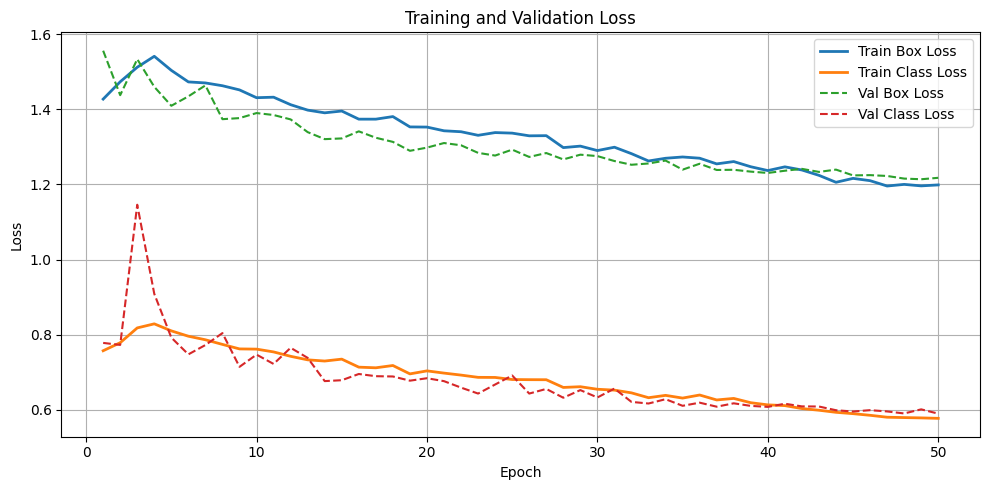

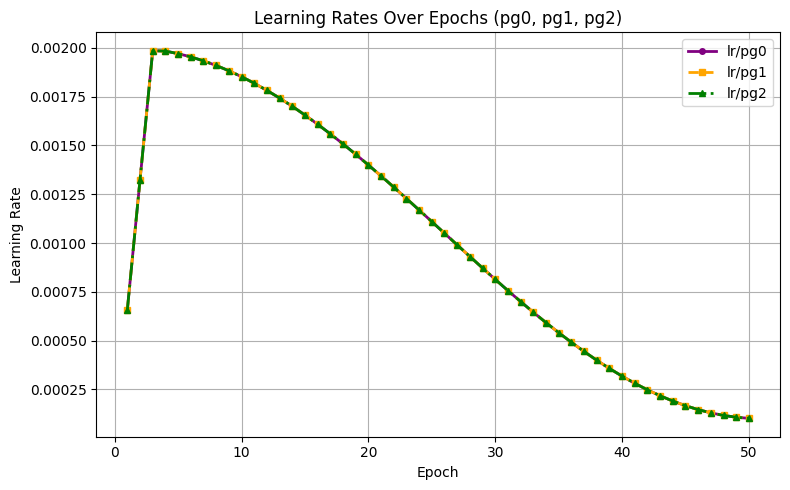

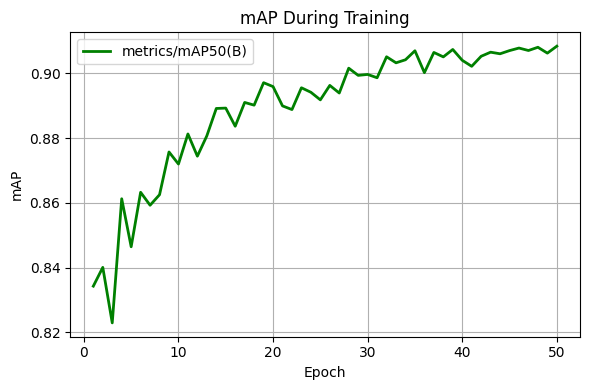

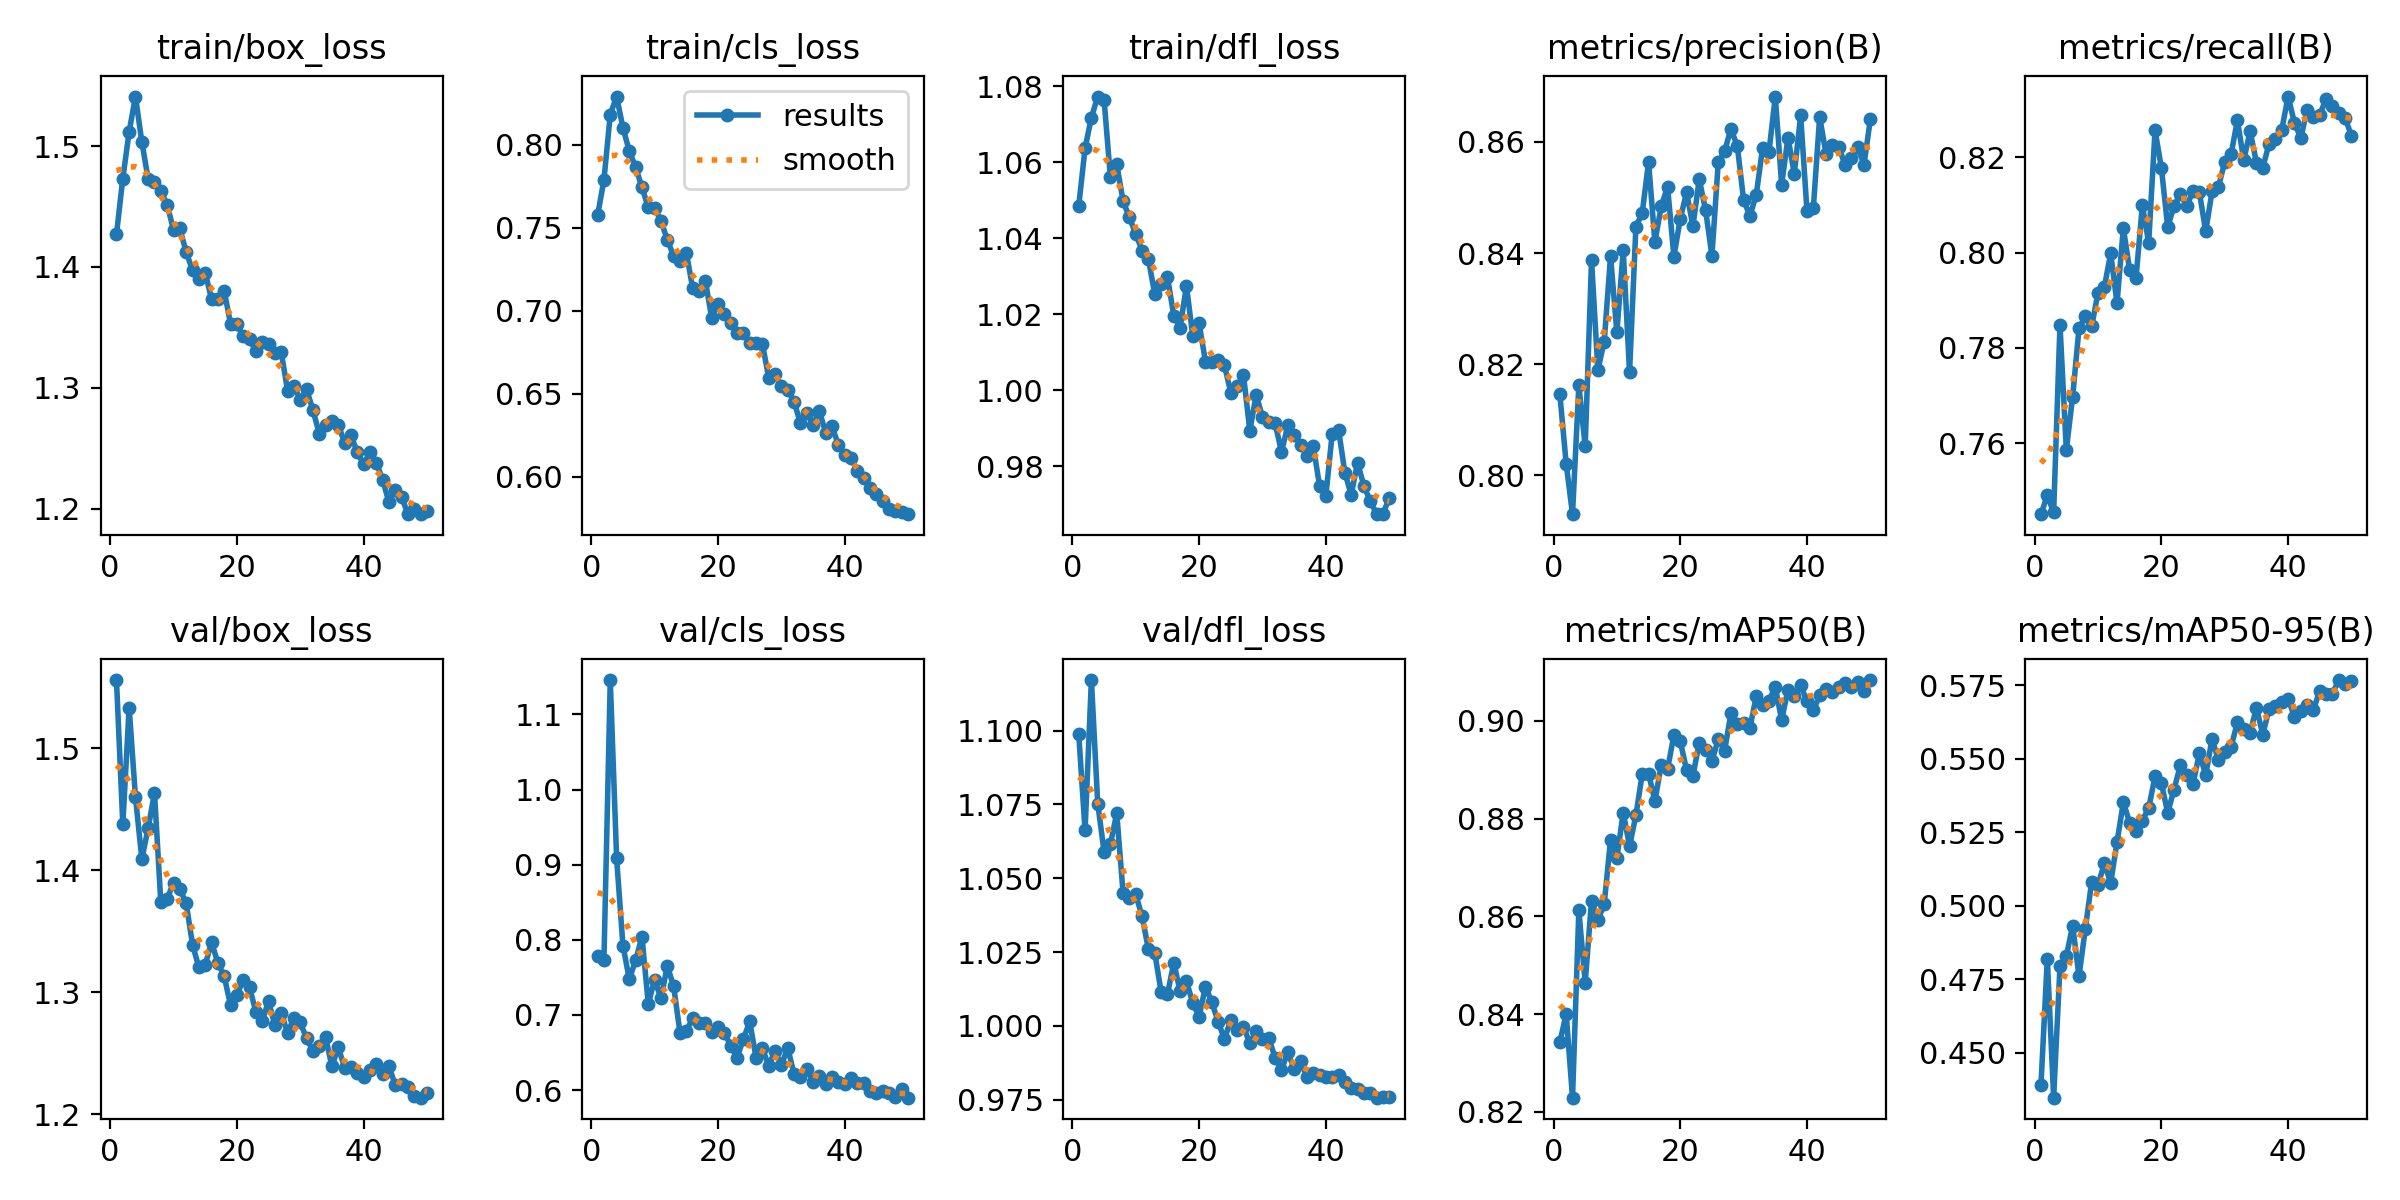

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / "teacher_final" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / "teacher_final" / "results.png"
img = Image.open(results_img)
display(img)

# Semi-supervised training using STAC: teacher generates pseudo-labels, student learns iteratively

In [10]:
# ================================
# 8. STAC-style self-training loop
# ================================
IMGZ = 640
TAU = 0.7
STAC_ITERS = 5
STU_EPOCHS = 50
BATCH = 12
DEVICE = "0"  # Change to "cpu" if no GPU available

print("Starting STAC self-training...")

for it in range(STAC_ITERS):
    print(f"\n=== STAC iteration {it+1}/{STAC_ITERS} ===")

    # 1. Generate pseudo-labels on UNLABELED images
    raw_label_dir = PSEUDO / "raw" / "labels"
    if raw_label_dir.exists():
        shutil.rmtree(raw_label_dir)
    raw_label_dir.mkdir(parents=True, exist_ok=True)

    print(f"Generating pseudo-labels on {len(list(UNLABELED_IMG_DIR.glob('*.*')))} unlabeled images...")
    YOLO(str(teacher_weights)).predict(
        source=str(UNLABELED_IMG_DIR),
        save_txt=True,
        save_conf=True,
        conf=TAU,
        project=str(PSEUDO),
        name="raw",
        device=DEVICE,
        imgsz=IMGZ,
        verbose=True,
    )

    # 2. Prepare student training labels by merging GT + pseudo labels
    labels_dir = STU_ROOT / "train" / "labels"
    # Clear existing student train labels
    for f in labels_dir.glob("*.txt"):
        f.unlink()

    # Copy ground-truth labels from labeled_train (teacher training GT)
    labeled_gt_dir = WORK / "labeled_train" / "labels"
    for gt_file in labeled_gt_dir.glob("*.txt"):
        shutil.copy(gt_file, labels_dir / gt_file.name)

        # If pseudo label exists for same image (only unlabeled images won't have GT)
        pseudo_file = raw_label_dir / gt_file.name
        if pseudo_file.exists():
            with open(labels_dir / gt_file.name, "a") as d, open(pseudo_file, "r") as p:
                d.write(p.read())

    # Add pseudo labels for unlabeled images (which have no GT)
    for pseudo_file in raw_label_dir.glob("*.txt"):
        if not (labels_dir / pseudo_file.name).exists():
            # This pseudo label corresponds to an unlabeled image
            # Copy it directly as student label
            shutil.copy(pseudo_file, labels_dir / pseudo_file.name)

    # Copy labeled + unlabeled images to STU_ROOT/train/images for student training
    # Clear previous images first
    images_dir = STU_ROOT / "train" / "images"
    for f in images_dir.glob("*.*"):
        f.unlink()

    # Copy labeled train images
    labeled_train_images = list((WORK / "labeled_train" / "images").glob("*.*"))
    for img in labeled_train_images:
        shutil.copy(img, images_dir / img.name)

    # Copy unlabeled images (pseudo-labeled) also
    unlabeled_images = list(UNLABELED_IMG_DIR.glob("*.*"))
    for img in unlabeled_images:
        shutil.copy(img, images_dir / img.name)

    print(f"Prepared training set: {len(list(images_dir.glob('*.*')))} images with merged labels.")

    # 3. Train student model on combined dataset
    student = YOLO(str(teacher_weights))
    student.train(
        data=str(WORK / "data_Sunflower_student.yaml"),  # your student YAML path
        epochs=STU_EPOCHS,
        imgsz=IMGZ,
        batch=BATCH,
        project=str(WORK),
        name=f"student_it{it+1}",
        device=DEVICE,
        verbose=True,
    )

    # 4. Update teacher weights to student's best weights for next iteration
    new_teacher_weights = WORK / f"student_it{it+1}" / "weights" / "best.pt"
    if not new_teacher_weights.exists():
        raise FileNotFoundError(f"Student weights not found: {new_teacher_weights}")
    teacher_weights = new_teacher_weights
    print(f"Teacher weights updated to iteration {it+1}'s student best weights.")

print("STAC self-training complete.")

Starting STAC self-training...

=== STAC iteration 1/5 ===
Generating pseudo-labels on 2770 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2770 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/unlabeled/images/20240116_122814-mp4_frame11_jpg.rf.89dbffb6bc606c0c43f3f6083ba9dd86.jpg: 640x640 64 Sunflowers, 20.9ms
image 2/2770 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/unlabeled/images/20240116_122814-mp4_frame12_jpg.rf.479de2762ee15cc258b3199caa859f97.jpg: 64

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels... 1069 images, 2770 backgrounds, 0 corrupt: 100%|██████████| 3839/3839 [00:02<00:00, 1832.07it/s]

train: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 507.6±468.6 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<00:00, 648.87it/s]

val: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.47G      1.284      1.807     0.9909        229        640: 100%|██████████| 320/320 [01:50<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.843      0.798      0.875      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.59G      1.398      1.758      1.029        445        640: 100%|██████████| 320/320 [01:46<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.793      0.814      0.861       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.63G      1.456      1.754      1.041        299        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        165      13823      0.786      0.804      0.855      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.23G       1.46      1.654      1.052         93        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.783      0.795      0.846      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.27G      1.456       1.68       1.05         47        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.823      0.801       0.87       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.31G      1.444      1.653      1.038        103        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.834      0.804      0.882      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.35G       1.42      1.655      1.033         95        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.819      0.803      0.872      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.38G      1.426      1.641      1.038        328        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.841      0.772       0.87      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.42G      1.423      1.659      1.035        362        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.753       0.82      0.849      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.46G      1.395      1.612      1.023        392        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.805      0.824       0.88      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       6.5G      1.395       1.63      1.021        352        640: 100%|██████████| 320/320 [01:46<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823        0.8      0.846      0.888      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.54G      1.381       1.59       1.02        228        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.839      0.824      0.891      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.19G      1.384      1.611       1.02        484        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.845      0.813      0.891      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.23G      1.359      1.636      1.013        348        640: 100%|██████████| 320/320 [01:45<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.831      0.828      0.891      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.27G      1.366      1.663      1.019        258        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.843      0.795      0.883      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.31G      1.367      1.627      1.015        390        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.843      0.793      0.878      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.35G      1.357      1.617      1.017        523        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        165      13823      0.834      0.832      0.893      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.53G      1.348       1.59      1.009        436        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.834      0.803      0.885      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.23G      1.337      1.623      1.007        279        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.819      0.837      0.887      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.23G      1.338      1.623      1.005        248        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.837      0.823      0.888      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.23G      1.328      1.566      1.004        328        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823       0.82      0.828      0.886       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.23G      1.328      1.622      1.006         88        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.814      0.836      0.888       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.23G      1.326      1.609      1.004        316        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.818       0.82      0.881      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.23G       1.32      1.635      1.001        425        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.858      0.795      0.887      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.26G      1.311      1.571          1        278        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823       0.83      0.843      0.899       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       7.3G        1.3      1.574     0.9951        212        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.852      0.808      0.894      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.34G      1.302      1.558     0.9994        199        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.865      0.776      0.881       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.38G      1.292      1.567     0.9917        264        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823       0.84      0.819      0.888      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.15G      1.297      1.613     0.9943        380        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.864      0.785      0.881      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.15G      1.297      1.545     0.9887        246        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.825      0.839      0.887      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.15G      1.287      1.567     0.9874        317        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823       0.83      0.828      0.889      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.15G      1.287      1.596     0.9962        432        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.825      0.826      0.876      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.15G      1.278      1.544     0.9822        196        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.858      0.812      0.895      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.18G      1.278      1.552     0.9902        194        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.836       0.83      0.887      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.22G      1.269      1.645     0.9826        397        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.852      0.816      0.891      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.26G      1.247      1.539     0.9749        195        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.816      0.838      0.878      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       6.3G      1.261      1.555     0.9809        283        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.858      0.795      0.883      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.34G      1.251       1.55     0.9767         64        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.839      0.831      0.892      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.38G      1.245      1.587     0.9761        253        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.826      0.839      0.883      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.05G      1.247      1.587     0.9725        542        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.805      0.831      0.863      0.528


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.09G      1.224      8.574     0.9772        246        640: 100%|██████████| 320/320 [01:44<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.827      0.836       0.88      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.13G      1.211      6.439     0.9733        377        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823       0.82      0.846      0.888      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.17G      1.169      14.72     0.9453        231        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.823      0.846      0.883      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.21G      1.188      13.18     0.9515          0        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823       0.81      0.826      0.864      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.25G       1.19        6.4     0.9733        312        640: 100%|██████████| 320/320 [01:43<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

                   all        165      13823      0.804      0.834       0.86      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.29G      1.202      2.754     0.9718        119        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.801      0.827      0.852      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.33G      1.181      7.239     0.9621         98        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.797      0.823      0.844      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.37G      1.183      6.577     0.9616        150        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.803      0.813      0.847      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.83G      1.149      12.91      0.939        112        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.803       0.79      0.838      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.14G       1.17      8.046     0.9543        408        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        165      13823      0.827      0.741      0.836      0.504



50 epochs completed in 1.510 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823       0.83      0.842      0.899      0.551
Speed: 0.2ms preprocess, 7.8ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1
Teacher weights updated to iteration 1's student best weights.

=== STAC iteration 2/5 ===
Generating pseudo-labels on 2770 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2770 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_D

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 1069 images, 2770 backgrounds, 0 corrupt: 100%|██████████| 3839/3839 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 417.5±35.0 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       7.6G      1.265      1.553     0.9865        229        640: 100%|██████████| 320/320 [01:51<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.834      0.836      0.894      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.62G        1.3      1.676     0.9965        445        640: 100%|██████████| 320/320 [01:47<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.825      0.815      0.878      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.63G       1.34      1.671      1.004        299        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823       0.82      0.818      0.878      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.24G      1.346      1.574       1.01         93        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.825      0.811      0.881      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.24G      1.354      1.599      1.012         47        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.844      0.794      0.884      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.24G      1.349      1.591      1.006        103        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.818      0.838      0.886      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.24G      1.341      1.602      1.006         95        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.839      0.822      0.895      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.24G      1.336      1.582      1.006        328        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.871      0.757      0.879      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.24G      1.329      1.587      1.003        362        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.834      0.823      0.888      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.24G      1.321      1.555     0.9982        392        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.837      0.811      0.884      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.24G      1.328       1.58     0.9968        352        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.803      0.844      0.886      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.27G      1.314      1.544     0.9981        228        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823       0.83      0.833      0.894      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.27G      1.313      1.566     0.9961        484        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823       0.85      0.815      0.891      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.27G      1.298      1.594     0.9933        348        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.823      0.829      0.885      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.27G      1.301      1.616     0.9996        258        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.814      0.842      0.887      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.28G      1.302      1.577     0.9945        390        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.874      0.769      0.877      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.28G        1.3      1.567     0.9976        523        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823       0.82      0.837      0.881      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.28G      1.289      1.556     0.9889        436        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823       0.85      0.804       0.89      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.28G      1.281      1.575     0.9894        279        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.836      0.825      0.882      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.28G      1.285      1.588     0.9885        248        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823       0.84      0.821      0.887      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.28G      1.272      1.521     0.9845        328        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.836      0.824      0.883      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.28G      1.277      1.578     0.9879         88        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.788      0.848      0.863      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.28G      1.269      1.571     0.9848        316        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        165      13823      0.806      0.839      0.872      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.28G      1.278      1.596     0.9864        425        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.857        0.8      0.876      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.28G      1.263      1.536     0.9842        278        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.844      0.831      0.894      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.28G      1.268      1.539     0.9838        212        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.867      0.793      0.889      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.28G      1.265      1.528     0.9848        199        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823       0.84      0.818      0.873      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.28G      1.254      1.535     0.9774        264        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.831      0.829      0.875      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.28G      1.261      1.581     0.9799        380        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.866      0.779      0.868      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.28G      1.265      1.513     0.9774        246        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.799      0.851      0.866      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.28G      1.255      1.531     0.9771        317        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.826      0.824      0.867      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.28G      1.257      1.564      0.983        432        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823       0.83      0.826      0.872       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.28G      1.249      1.517      0.973        196        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.847      0.818      0.886      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.28G       1.25      1.519     0.9796        194        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        165      13823      0.822      0.814      0.857      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.28G      1.243      1.614     0.9717        397        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.835      0.819      0.874      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.28G      1.224      1.506     0.9668        195        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823        0.8      0.839       0.86      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.28G      1.236      1.515     0.9698        283        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.828      0.817      0.866      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.28G      1.227      1.513     0.9677         64        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.792      0.844      0.863      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.28G      1.226       1.55     0.9701        253        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823        0.8      0.834      0.852      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.28G      1.226      1.542     0.9692        542        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.811      0.808      0.849      0.519


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.28G      1.202      8.521      0.971        246        640: 100%|██████████| 320/320 [01:45<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.783      0.781       0.83      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.28G       1.19      6.772     0.9668        377        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.814      0.825      0.868      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.28G      1.151      14.83     0.9396        231        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.798      0.796      0.839      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.28G      1.169       12.9     0.9459          0        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.813      0.706      0.819      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.28G      1.177      6.878     0.9695        312        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.775      0.784      0.825      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.28G      1.189      2.603     0.9683        119        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.784      0.763       0.82      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.28G      1.168      7.116     0.9583         98        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.778      0.714        0.8      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.28G      1.173      6.194     0.9572        150        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.787      0.696      0.801      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.28G      1.137      11.86      0.935        112        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.775      0.705      0.796      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.28G       1.16      7.821     0.9507        408        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

                   all        165      13823      0.784      0.692      0.798      0.481



50 epochs completed in 1.513 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.834      0.836      0.894      0.551
Speed: 0.2ms preprocess, 9.3ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2
Teacher weights updated to iteration 2's student best weights.

=== STAC iteration 3/5 ===
Generating pseudo-labels on 2770 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2770 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_D

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 1069 images, 2770 backgrounds, 0 corrupt: 100%|██████████| 3839/3839 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 674.1±482.7 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.59G      1.204      1.527     0.9668        229        640: 100%|██████████| 320/320 [01:51<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.821      0.824      0.881      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       5.6G      1.305      1.671     0.9988        445        640: 100%|██████████| 320/320 [01:47<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823       0.83      0.808      0.876      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.64G      1.342      1.673      1.004        299        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.817       0.81      0.875      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       6.2G       1.35      1.576      1.012         93        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.819      0.823      0.881      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.24G      1.353      1.598      1.012         47        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.865      0.777      0.886      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.24G      1.348      1.587      1.005        103        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.801      0.851      0.883      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.24G      1.336      1.597      1.005         95        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        165      13823       0.84      0.823      0.891       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.24G      1.334      1.578      1.006        328        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823       0.88      0.753       0.88      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.24G       1.33      1.586      1.004        362        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.813      0.829      0.881      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.24G      1.319      1.553      0.998        392        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.809      0.825      0.872      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.24G      1.327      1.578     0.9975        352        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.816      0.834      0.889      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.24G      1.311      1.542     0.9986        228        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.827      0.837      0.892      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.24G      1.311      1.564     0.9962        484        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.842      0.824      0.893      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.24G      1.294      1.594     0.9898        348        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.822      0.841      0.891      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.24G        1.3      1.613     0.9974        258        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.814      0.845      0.886      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.24G        1.3      1.576     0.9943        390        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.856      0.787      0.875      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.24G      1.298      1.566     0.9994        523        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.833      0.833      0.888      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.24G      1.292      1.551     0.9904        436        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.831      0.823      0.888      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.24G      1.285      1.574     0.9912        279        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.817      0.844      0.878      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.24G      1.283      1.587      0.989        248        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.832      0.826       0.88      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.24G      1.275      1.522     0.9855        328        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.837      0.823      0.883      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.24G      1.277      1.575     0.9882         88        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.787      0.849      0.863      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.24G       1.27      1.569     0.9846        316        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

                   all        165      13823      0.795      0.836       0.86      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.24G      1.277      1.592     0.9865        425        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.857      0.795      0.872      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.24G      1.265      1.538     0.9836        278        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        165      13823      0.834      0.837      0.892      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.24G      1.265      1.539     0.9824        212        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.857      0.807      0.885      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.24G      1.265      1.525     0.9842        199        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.852      0.799       0.87      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.24G      1.256      1.534     0.9797        264        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        165      13823      0.828      0.831      0.871      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.24G      1.265       1.58     0.9805        380        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.852      0.792      0.863      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.24G      1.266      1.509      0.976        246        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.785      0.858       0.86       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.24G      1.254      1.531     0.9761        317        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.819      0.822      0.864       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.24G      1.257      1.559     0.9852        432        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.824      0.822      0.869      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.24G      1.251      1.514     0.9753        196        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.845      0.798      0.879       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.27G       1.25      1.514     0.9794        194        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.827      0.812      0.859      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.27G       1.24      1.618     0.9728        397        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.839      0.824      0.877      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.27G      1.224      1.499     0.9667        195        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.819      0.825      0.867      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.27G      1.234      1.514      0.971        283        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.832      0.807      0.864      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.27G      1.226       1.51      0.968         64        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.806      0.845      0.871       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.27G      1.226      1.543     0.9706        253        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.796      0.832      0.848      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.27G      1.227      1.541     0.9677        542        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.801      0.821      0.847      0.516


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.27G      1.204      8.549     0.9706        246        640: 100%|██████████| 320/320 [01:45<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.776      0.764      0.811      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.27G      1.196      6.403     0.9675        377        640: 100%|██████████| 320/320 [01:44<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.822      0.787      0.852      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.27G      1.154      14.82     0.9402        231        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.824      0.784      0.847      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.27G      1.172      12.97     0.9454          0        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.797      0.717      0.812      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.27G       1.18      6.655     0.9676        312        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.762      0.802      0.814      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.27G      1.191      2.699     0.9673        119        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823       0.78      0.771      0.818      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.27G      1.168      7.052     0.9576         98        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.783      0.723      0.805      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.27G      1.173      6.219     0.9574        150        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.783      0.708      0.797      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.27G      1.139      11.82     0.9349        112        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        165      13823       0.78      0.704      0.794      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.27G      1.163      7.861     0.9516        408        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.794      0.701        0.8      0.482



50 epochs completed in 1.513 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.842      0.824      0.893      0.544
Speed: 0.4ms preprocess, 10.5ms inference, 0.0ms loss, 19.9ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3
Teacher weights updated to iteration 3's student best weights.

=== STAC iteration 4/5 ===
Generating pseudo-labels on 2770 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2770 /kaggle/working/PSEUDO_STAC/Pseudo_Converted

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 1069 images, 2770 backgrounds, 0 corrupt: 100%|██████████| 3839/3839 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 315.1±161.3 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       7.5G      1.242      1.539     0.9793        229        640: 100%|██████████| 320/320 [01:52<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.844      0.827      0.897      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       5.6G      1.263       1.64     0.9877        445        640: 100%|██████████| 320/320 [01:47<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.831      0.794      0.864      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.63G      1.296      1.645     0.9899        299        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.848      0.809       0.89      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       6.2G        1.3      1.544     0.9965         93        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.836      0.813      0.876      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       6.2G      1.309      1.567     0.9964         47        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.852      0.799      0.889       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       6.2G      1.307       1.56     0.9922        103        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.766      0.869      0.869       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       6.2G      1.301      1.571     0.9926         95        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.848      0.805      0.887      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.23G      1.303      1.558     0.9944        328        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.864      0.783      0.884      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.23G      1.294      1.559     0.9907        362        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.807       0.83      0.869      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.23G      1.284      1.526     0.9871        392        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.823      0.828      0.871      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.23G      1.294      1.553     0.9871        352        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.769      0.868      0.862      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.23G      1.283      1.515     0.9888        228        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.803      0.847      0.878      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.23G      1.283      1.542     0.9874        484        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.831       0.83      0.887      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.23G      1.284      1.579     0.9895        348        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.803       0.85      0.878      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.23G      1.292      1.601     0.9969        258        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.819      0.839      0.882      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.23G      1.286      1.559     0.9902        390        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        165      13823      0.837      0.812      0.874      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.23G      1.286      1.548     0.9964        523        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.802      0.852      0.873      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.23G       1.28      1.536     0.9897        436        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.849      0.801      0.886       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.23G      1.273      1.555     0.9888        279        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.769      0.876      0.855       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.23G      1.277      1.578     0.9878        248        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823       0.82      0.841      0.872      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.26G      1.263      1.504     0.9832        328        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.823      0.826      0.871      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.26G      1.269       1.56     0.9862         88        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.783      0.853      0.853      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.26G      1.259      1.556     0.9825        316        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.793      0.847      0.862      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.27G      1.265      1.575     0.9844        425        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.854      0.783      0.856      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.27G       1.26      1.521     0.9852        278        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823       0.83      0.838       0.88      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.27G      1.255      1.518     0.9781        212        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        165      13823      0.853      0.811      0.874      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.27G      1.255      1.507     0.9825        199        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.825      0.816      0.857      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.27G      1.246      1.516     0.9756        264        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.794      0.851      0.853      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.27G      1.249       1.56     0.9778        380        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.798      0.836      0.852      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.27G      1.254      1.492     0.9756        246        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.778      0.861      0.854      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.27G      1.246      1.506     0.9745        317        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.805      0.802      0.834      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.27G      1.247      1.539     0.9823        432        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823       0.81      0.826      0.854      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.27G      1.241      1.496     0.9704        196        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823       0.82      0.808      0.868      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.27G      1.243      1.494     0.9773        194        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823       0.81      0.777      0.839      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.27G      1.232      1.582       0.97        397        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.824      0.796       0.85       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.27G      1.219      1.475     0.9667        195        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.804      0.777      0.842      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.27G      1.234      1.488     0.9711        283        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823       0.81      0.775      0.846      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.27G      1.223      1.478     0.9674         64        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.768      0.809      0.834      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.27G      1.222      1.511     0.9685        253        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.771      0.775       0.83      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.27G      1.222       1.51     0.9659        542        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.775      0.763      0.825      0.501


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.27G      1.198      8.657     0.9666        246        640: 100%|██████████| 320/320 [01:45<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.775      0.704      0.801      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.27G      1.187      6.757     0.9633        377        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823        0.8      0.741      0.831      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.27G      1.151       14.5     0.9395        231        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.777      0.686      0.792      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.27G      1.168      13.09     0.9437          0        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.784      0.693      0.805      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.27G      1.175      6.936      0.966        312        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.756      0.753      0.808      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.27G      1.188      2.519      0.967        119        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.771       0.73      0.806      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.27G      1.166      7.019     0.9569         98        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.757      0.664      0.778       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.27G      1.171      6.086     0.9571        150        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.761      0.637      0.771      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.27G      1.139      11.68     0.9338        112        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.755      0.676      0.776      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.27G      1.161      7.621       0.95        408        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.767      0.636      0.774      0.466



50 epochs completed in 1.514 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.844      0.828      0.897      0.556
Speed: 0.2ms preprocess, 8.9ms inference, 0.0ms loss, 21.2ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4
Teacher weights updated to iteration 4's student best weights.

=== STAC iteration 5/5 ===
Generating pseudo-labels on 2770 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2770 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 1069 images, 2770 backgrounds, 0 corrupt: 100%|██████████| 3839/3839 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 410.5±53.3 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.51G      1.177      1.498     0.9584        229        640: 100%|██████████| 320/320 [01:51<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        165      13823      0.808       0.76      0.832      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.61G      1.263      1.634     0.9858        445        640: 100%|██████████| 320/320 [01:47<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.823      0.805      0.865      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.64G      1.295      1.645     0.9874        299        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        165      13823      0.833      0.813      0.881      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.24G      1.305      1.546     0.9949         93        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.836      0.813      0.877      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.24G      1.309      1.564     0.9953         47        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.862      0.787      0.889       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.24G      1.309      1.561      0.991        103        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.763      0.874      0.861      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.24G      1.297      1.573     0.9908         95        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.852      0.798      0.887      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.24G      1.301      1.554     0.9939        328        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.849      0.783      0.872      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.24G       1.29      1.558     0.9909        362        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.803      0.831      0.867      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.24G      1.278       1.52      0.984        392        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        165      13823      0.818      0.824      0.866      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.24G      1.294      1.547      0.985        352        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.773      0.857      0.852      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.28G      1.277      1.511      0.986        228        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823       0.81      0.846      0.878       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.28G      1.278      1.537     0.9849        484        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.818      0.838      0.883      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.28G      1.286      1.581     0.9889        348        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.807       0.85      0.878       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.28G      1.291      1.604     0.9958        258        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.786       0.86      0.874      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.28G      1.287       1.56     0.9894        390        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.845       0.79      0.869      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.28G      1.288      1.551     0.9951        523        640: 100%|██████████| 320/320 [01:45<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.791      0.859       0.87      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.28G      1.278      1.536     0.9834        436        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.833      0.812      0.877      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.28G      1.272      1.551     0.9866        279        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        165      13823      0.795      0.852      0.862      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.28G      1.275      1.573     0.9875        248        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.826      0.823       0.86      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.28G      1.263      1.502     0.9833        328        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.777      0.852      0.842      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.28G       1.27      1.559     0.9851         88        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.774      0.863      0.847      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.28G      1.258      1.556     0.9801        316        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

                   all        165      13823      0.787      0.847      0.854       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.28G      1.265      1.579     0.9828        425        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823       0.84      0.804      0.861      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.28G      1.256       1.52     0.9829        278        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.833      0.838      0.884      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.28G      1.255      1.512     0.9791        212        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

                   all        165      13823      0.839      0.814      0.865      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.28G      1.255      1.505     0.9835        199        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.803      0.824      0.843      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.28G      1.246      1.513     0.9749        264        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        165      13823      0.796      0.835       0.84      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.28G       1.25      1.561     0.9774        380        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.799      0.824      0.839      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.28G      1.256       1.49     0.9741        246        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.753      0.866      0.833      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.28G      1.245      1.506     0.9741        317        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        165      13823      0.782      0.825      0.834      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.28G      1.247      1.538     0.9823        432        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        165      13823      0.811       0.82      0.855      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.28G      1.244      1.498     0.9721        196        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.804      0.828      0.866      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.28G      1.244      1.491     0.9786        194        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823       0.81      0.793      0.845      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.28G      1.234      1.579     0.9707        397        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.828      0.799      0.862      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.28G       1.22      1.474     0.9671        195        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.798      0.795      0.843      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.28G      1.231      1.482     0.9708        283        640: 100%|██████████| 320/320 [01:46<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

                   all        165      13823      0.812      0.772       0.85      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.28G      1.225      1.482     0.9691         64        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.781      0.832      0.847       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.28G       1.22      1.514     0.9695        253        640: 100%|██████████| 320/320 [01:45<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.777      0.812      0.835      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.32G       1.22      1.515     0.9666        542        640: 100%|██████████| 320/320 [01:46<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

                   all        165      13823      0.789      0.767       0.84      0.513


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.32G      1.199      8.501     0.9698        246        640: 100%|██████████| 320/320 [01:45<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        165      13823      0.772        0.7      0.796       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.32G      1.185      6.813     0.9639        377        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.818      0.773      0.853      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.32G      1.148      14.38     0.9376        231        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.777      0.739      0.808      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.32G      1.168      13.16     0.9442          0        640: 100%|██████████| 320/320 [01:44<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.772      0.686      0.792      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.32G      1.176      7.028     0.9666        312        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        165      13823      0.759      0.773      0.813      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.32G      1.189      2.646     0.9664        119        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823      0.789       0.73       0.81      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.32G      1.165      6.386     0.9564         98        640: 100%|██████████| 320/320 [01:44<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]

                   all        165      13823       0.76      0.697      0.787      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.32G       1.17      5.985     0.9572        150        640: 100%|██████████| 320/320 [01:44<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        165      13823      0.779       0.66      0.785      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.32G      1.137      11.79     0.9354        112        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        165      13823      0.758      0.665      0.775      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.32G      1.159      7.781     0.9512        408        640: 100%|██████████| 320/320 [01:44<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        165      13823      0.766      0.652      0.778      0.466



50 epochs completed in 1.515 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/best.pt...
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.852      0.798      0.887      0.542
Speed: 0.2ms preprocess, 9.4ms inference, 0.0ms loss, 12.2ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5
Teacher weights updated to iteration 5's student best weights.
STAC self-training complete.


# Visualization of Student Training Results

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


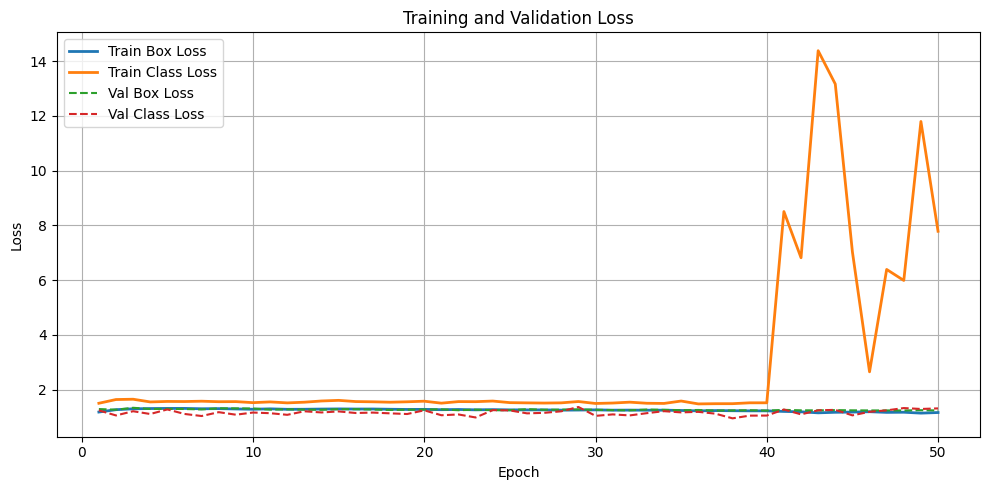

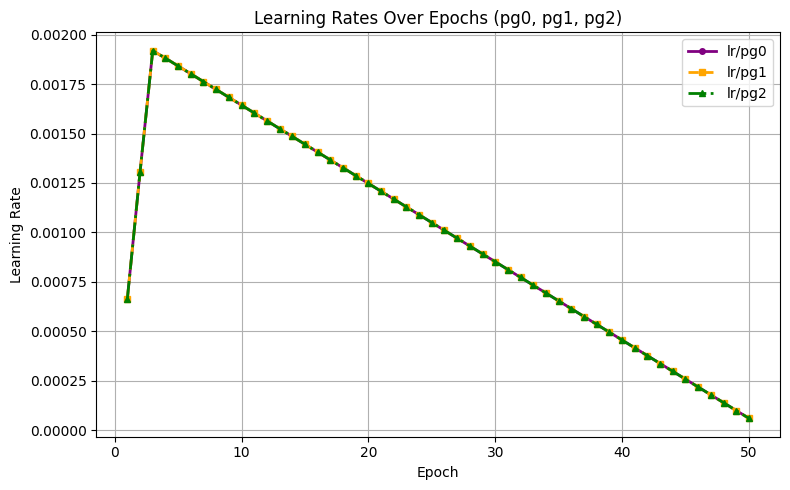

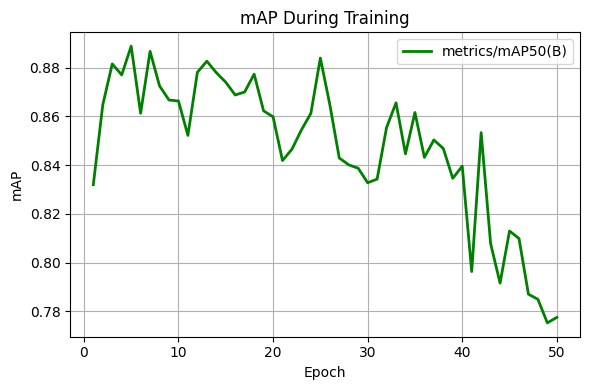

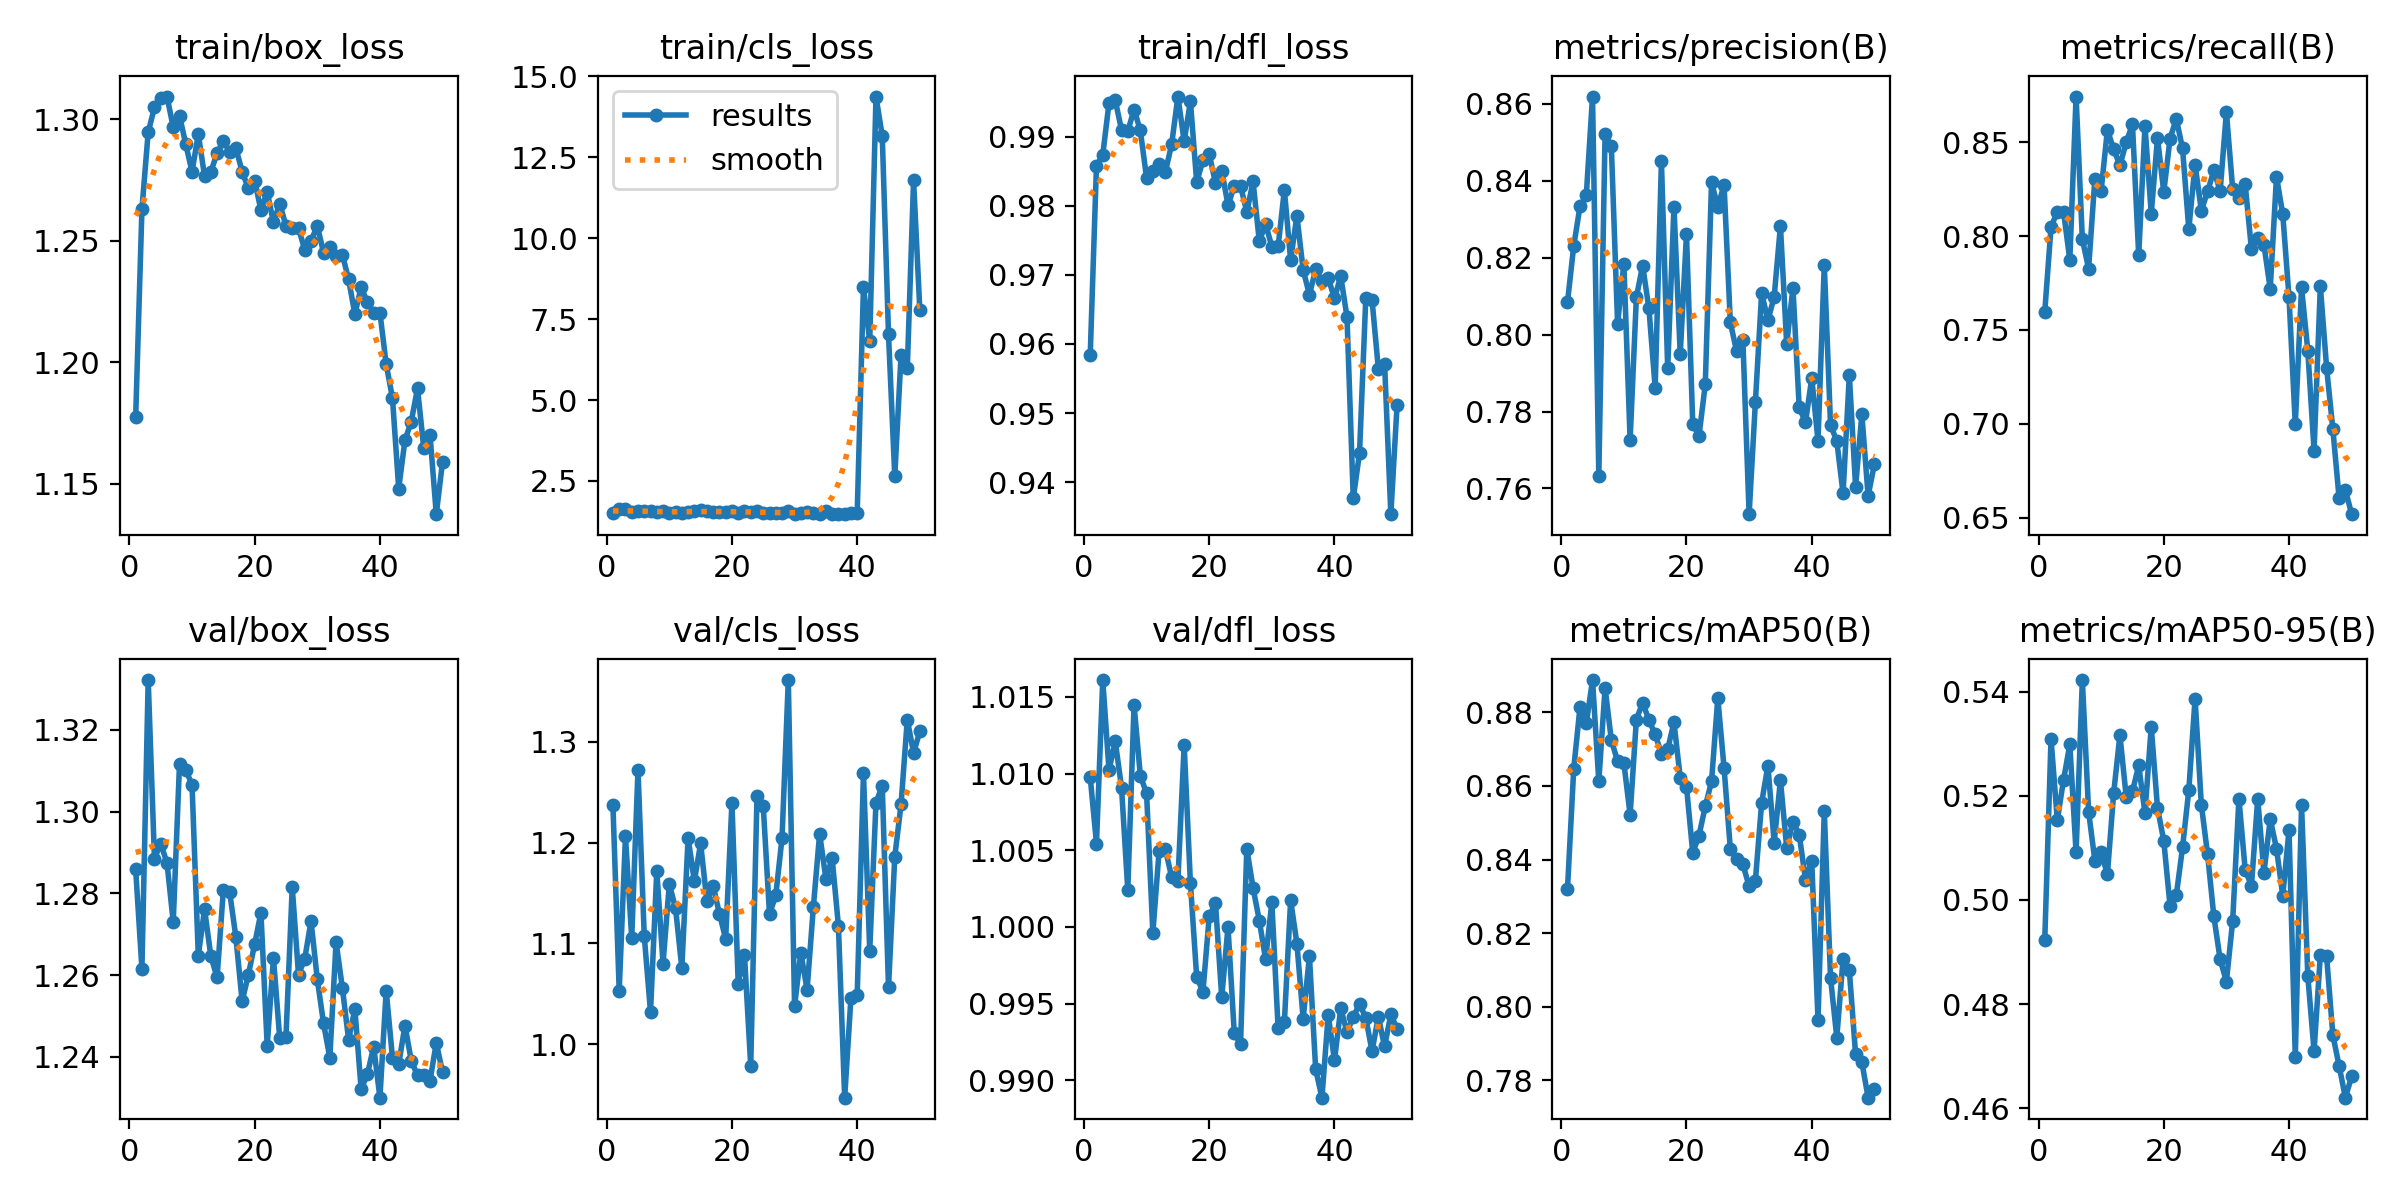

In [11]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / f"student_it{it+1}" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / f"student_it{it+1}" / "results.png"
img = Image.open(results_img)
display(img)

# Final Model Evaluation 

In [12]:
print("\nEvaluating …")
model   = YOLO(str(teacher_weights))
results = model.val(
    data=str(teacher_data_yaml_path),
    imgsz=640,
    batch=4,
    device=DEVICE,   # use same DEVICE string as before
    verbose=True
)

# Extract metrics depending on Ultralytics version
try:
    # new API
    metrics = results.results_dict
    print("\nValidation metrics")
    print(f"Precision (mP)   : {metrics.get('metrics/precision(B)', 0):.4f}")
    print(f"Recall (mR)      : {metrics.get('metrics/recall(B)', 0):.4f}")
    print(f"mAP@0.50         : {metrics.get('metrics/mAP50(B)', 0):.4f}")
    print(f"mAP@0.50:0.95    : {metrics.get('metrics/mAP50-95(B)', 0):.4f}")
except Exception as e:
    print("Could not parse metrics from results object:", e)
    print(results)

# import random, matplotlib.pyplot as plt

# # pick from test or valid images
# cands = list((WORK/"0_yolo_split"/"test"/"images").glob(".")) or list((WORK/"0_yolo_split"/"valid"/"images").glob("."))

# if cands:
#     imgs = random.sample(cands, min(4, len(cands)))  # pick up to 4 random images
#     fig, axes = plt.subplots(1, 4, figsize=(20, 6))
#     axes = axes.flatten()

#     for ax, img_path in zip(axes, imgs):
#         print("Visualising:", img_path.name)
#         pred = model.predict(
#             source=str(img_path),
#             imgsz=640,
#             conf=0.25,
#             device=DEVICE,
#             verbose=False
#         )[0]
#         ax.imshow(pred.plot()[:, :, ::-1])  # convert BGR to RGB
#         ax.axis("off")
#         ax.set_title(img_path.name, fontsize=10)

#     # hide unused axes if <4 images
#     for ax in axes[len(imgs):]:
#         ax.axis("off")

#     plt.tight_layout()
#     plt.show()

# else:
#     print("No images found for visualization.")


Evaluating …
Ultralytics 8.3.180 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2087.6±648.7 MB/s, size: 94.2 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache... 118 images, 0 backgrounds, 0 corrupt: 100%|██████████| 118/118 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  6.45it/s]
invalid value encountered in less
invalid value encountered in less


                   all        118      10404      0.851      0.789      0.879      0.538
Speed: 1.4ms preprocess, 26.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/val

Validation metrics
Precision (mP)   : 0.8512
Recall (mR)      : 0.7894
mAP@0.50         : 0.8792
mAP@0.50:0.95    : 0.5380
